# Variational One-Class Autoencoder (VOCAE) on real data

In [4]:
!pip install git+https://github.com/jeanollion/dataset_iterator.git
!pip install git+https://github.com/jeanollion/distnet.git
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt

# DRIVE
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

# copy data locallly
dataset_dir = f"/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/"
!cp "/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/train_val_eval.h5" "/home/train_val_eval.h5"
dataset_path = "/home/train_val_eval.h5"
print(dataset_path)

!nvidia-smi

  Cloning https://github.com/jeanollion/dataset_iterator.git to /tmp/pip-req-build-2mvtzc4d
  Running command git clone -q https://github.com/jeanollion/dataset_iterator.git /tmp/pip-req-build-2mvtzc4d
  Created wheel for dataset-iterator: filename=dataset_iterator-0.0.1-cp36-none-any.whl size=35945 sha256=60b30bb974635a1f81853fe90502fc3d4d5ef08ae15383eae2931521c5ccf092
  Stored in directory: /tmp/pip-ephem-wheel-cache-8xrumn42/wheels/e1/b1/4a/efb8888afaa53e058db8520c203e13af93ca10b2a8d42ab098
Successfully built dataset-iterator
  Cloning https://github.com/jeanollion/distnet.git to /tmp/pip-req-build-es9hy8os
  Running command git clone -q https://github.com/jeanollion/distnet.git /tmp/pip-req-build-es9hy8os
  Created wheel for distnet: filename=distnet-0.0.1-cp36-none-any.whl size=51344 sha256=2d40633dc3c8ea3cf76bc62a8986fbb9af8a5e39dddae33b7a571bbce204d7b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-xktadpkg/wheels/12/6e/51/1b4851b9716ec2b0d0db57e350ee2eea8d95cb244578fea6f8
Su

## Load dataset

In [ ]:
dataset_path = "/home/bact.h5"

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
out_file= h5py.File(dataset_path, 'w')
out_file.create_dataset("cifar10/train/images", data = train_images)
out_file.create_dataset("cifar10/train/labels", data = train_labels)
out_file.create_dataset("cifar10/eval/images", data = test_images)
out_file.create_dataset("cifar10/eval/labels", data = test_images)
out_file.close()

# sort per class
dataset_path_class = "/home/cifar10_class.h5"

out_file= h5py.File(dataset_path_class, 'w')
for c in range(10):
    out_file.create_dataset("cifar10/train/{}/images".format(c), data = train_images[train_labels.squeeze(-1)==c])
    out_file.create_dataset("cifar10/train/{}/labels".format(c), data = train_labels[train_labels.squeeze(-1)==c])
    out_file.create_dataset("cifar10/eval/{}/images".format(c), data = test_images[test_labels.squeeze(-1)==c])
    out_file.create_dataset("cifar10/eval/{}/labels".format(c), data = test_labels[test_labels.squeeze(-1)==c])
out_file.close()

170500096/170498071 [==============================] - 11s 0us/step


In [9]:
from dataset_iterator import MultiChannelIterator, PreProcessingImageGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from distnet.utils.pre_processing import random_scaling

corruption_function = lambda im: im + np.random.normal(0, 10, im.shape) # define here a corruption function that input a singla image and return and image of same shape
image_scaling = PreProcessingImageGenerator(lambda im:im/255.) # simple scaling of 8-bit images -> data in [0, 1]

def global_contrast_normalization(im, s=1, lmda=1, epsilon=1e-9):
    mu = np.mean(im)
    im = im - mu
    contrast = np.sqrt(lmda + np.mean(im**2))
    im = s * im / max(contrast, epsilon)
    return im

data_gen_in = ImageDataGenerator(
                              horizontal_flip=True,
                            #   vertical_flip=True,
                              height_shift_range=0.3,
                              width_shift_range=0.3,
                              channel_shift_range=0.3,
                            #   rescale=1./255, # to have values in range [0, 1]
                              fill_mode="nearest",)
                            #   preprocessing_function=corruption_function)


def corruption_random_scaling(batch_by_channel):
    batch_by_channel[1] = np.copy(batch_by_channel[0]) # creating channel 1
    batch_by_channel[0] = corruption_function(batch_by_channel[0])  # corruption on channel 0 only
    batch_by_channel[0], batch_by_channel[1] = random_scaling(batch_by_channel[0]), random_scaling(batch_by_channel[1])
    # batch_by_channel[0], batch_by_channel[1] = global_contrast_normalization(batch_by_channel[0]), global_contrast_normalization(batch_by_channel[1])


def random_scaling(batch_by_channel):
    batch_by_channel[0] = random_scaling(batch_by_channel[0])


# train set, interest class only
x_train = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw", None],
                                group_keyword = "train", 
                                input_channels=[0],
                                output_channels=[1], 
                                image_data_generators=[data_gen_in, None],
                                # channels_postprocessing_function=corruption_random_scaling,
                                channels_preprocessing_function=random_scaling,
                                batch_size=4
                                )

# validation set, interest class only
x_val = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw", None],
                                group_keyword = "val",
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators=[data_gen_in, None],
                                # channels_postprocessing_function=corruption_random_scaling,
                                channel_preprocessing_function=random_scaling,
                                batch_size=4
                                )

# evaluation set, nominal and anormal classes
x_test_norm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_norm",
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators=[image_scaling],
                                batch_size=64
                                )

x_test_norm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_anom",
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators=[image_scaling],
                                batch_size=64
                                )
# from itertools import chain
# y_iter = chain(l1, l2)

print(f"Number of batches {len(x_train)} of size {len(x_train[0][0])}")

TypeError: ignored

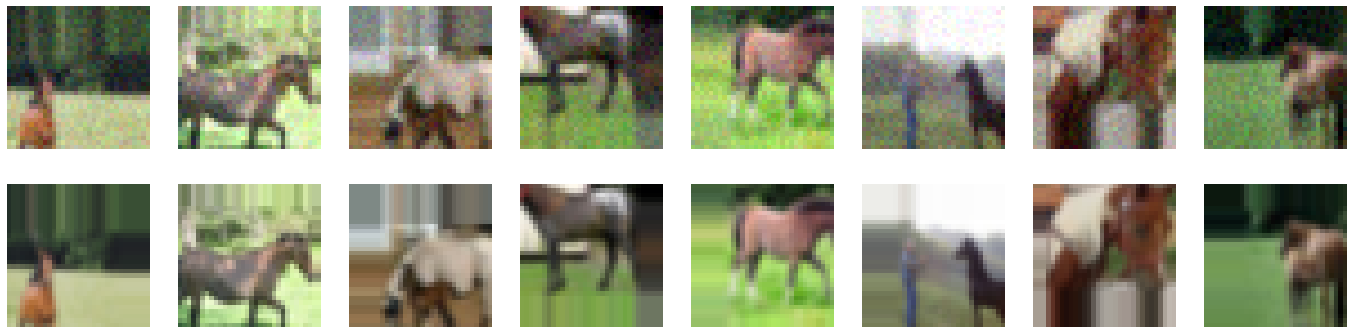

In [ ]:
def plot_images(batch_x, batch_y, n=3, labx=None, laby=None):
  plt.figure(figsize=(n*3, 6))
  for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(np.clip(batch_x[i], 0, 1))
    if labx is not None:
        plt.title(label=int(labx[i].squeeze(-1)))
    plt.axis("off")
    plt.subplot(2, n, n+i+1)
    plt.imshow(np.clip(batch_y[i], 0, 1))
    if laby is not None:
        plt.title(label=int(labx[i].squeeze(-1)))
    plt.axis("off")
    # To get images and labels

bx, by = x_train[1]

plot_images(bx, by, n=8, labx=None, laby=None)

In [ ]:
# look for nan in the train set

for b in range(len(x_train)):
    bx, by = x_train[b]
    for i in range(len(bx)):
        im = bx[i]
        im_sum = np.sum(im)
        has_nan = np.isnan(im_sum)
        if has_nan:
            print(b, i)
    for j in range(len(by)):
        imy = by[j]
        im_sumy = np.sum(imy)
        has_nany = np.isnan(im_sumy)
        if has_nany:
            print(b, j)

for b in range(len(x_val)):
    bx, by = x_train[b]
    for i in range(len(bx)):
        im = bx[i]
        im_sum = np.sum(im)
        has_nanv = np.isnan(im_sum)
        if has_nanv:
            print(b, i)
    for j in range(len(by)):
        imy = by[j]
        im_sumy = np.sum(imy)
        has_nanvy = np.isnan(im_sumy)
        if has_nanvy:
            print(b, j)

if not has_nan and not has_nany:
    print("Training set OK")

if not has_nanv and not has_nanvy:
    print("Validation set OK")

Training set OK
Validation set OK


## Define model

In [ ]:
from uad.models.architecture import get_unet_vae

n_filters = 60
n_contractions = 3
input_dims = (32, 32, 3)
latent_depth = n_filters * int(2**n_contractions)
latent_dims = (int(32 / (2**n_contractions)), int(32 / (2**n_contractions)), latent_depth)
batchnorm, dropout = False, 0
spatial_dropout = 0.2
k_size = (3, 3)

encoder, decoder = get_unet_vae(n_filters=n_filters, n_contractions=n_contractions, 
                      input_dims=input_dims, k_size=k_size, batchnorm=batchnorm, 
                      dropout=dropout, spatial_dropout=spatial_dropout, activation_function="leaky_relu")

print(encoder.summary(), decoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 60)   1680        encoder_inputs[0][0]             
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 60)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 60)   32460       leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [ ]:
from uad.models.variational_autoencoder import OC_VAE

LAMBDAS = (0.3, 0.1)

del oc_vae

oc_vae = OC_VAE(encoder, decoder, input_dims=input_dims,
                latent_dims=latent_dims, LAMBDAS=LAMBDAS)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

oc_vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = oc_vae.fit(x_train, validation_data=x_val, epochs=80, callbacks=[tensorboard_callback])

Epoch 1/80
39/75 [==============>...............] - ETA: 2s - loss: nan - reconstruction_loss: inf - centripetal_loss: nan - kl_loss: nan

KeyboardInterrupt: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
import os
os.chdir("/content/gdrive/My Drive/BACMMAN_DISTNET/models/")
tf.keras.models.save_model(oc_vae, "oc_vae_CIFAR_UNet")

In [ ]:
import os
os.chdir("/content/gdrive/My Drive/BACMMAN_DISTNET/models/")

vae = tf.keras.models.load_model("oc_vae_CIFAR_UNet")